# Big data analysis homework 2
## Name: liusheng
## ID:1801212891

# Problem 1
Loading data first

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("climate_change_1.csv", index_col=0)
train_data = data.loc[:2006,:]
test_data = data.loc[2007:,:]
train_data.shape
data.head()

(284, 10)

,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
Year,,,,,,,,,,
1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


### 1. Implement a function closed_form_1 that computes this closed form solution given the features 𝐗, labels Y (using Python or Matlab).

Apparently, the some variables in data set are highly correlated, so the correlation coefficient of the correlated variables are unstable.For example, CO2 and N2O, CH4 and CFC-12, is highly correlated, the correlation coefficeints of those variables are not trusted

In [6]:
temp = train_data.iloc[:,1:-1].corr()
temp[temp>0.9]

def closed_form_1(x,y, constant = True):
    if constant:
        x["Constant"]=1
    columns = x.columns
    x = np.matrix(x)
    y = np.matrix(y).T
    coeff = (x.T@x).I@(x.T@y)
    result = pd.Series(coeff.A1, index=columns, 
                       name="correlation coefficient")
    return result

coeff = closed_form_1(train_data.iloc[:,1:-1], train_data.Temp)
coeff

,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols
MEI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO2,NaN,1.00000,NaN,0.97672,NaN,NaN,NaN,NaN
CH4,NaN,NaN,1.000000,NaN,NaN,0.963616,NaN,NaN
N2O,NaN,0.97672,NaN,1.00000,NaN,NaN,NaN,NaN
CFC-11,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
CFC-12,NaN,NaN,0.963616,NaN,NaN,1.000000,NaN,NaN
TSI,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Aerosols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


MEI           0.064205
CO2           0.006457
CH4           0.000124
N2O          -0.016528
CFC-11       -0.006630
CFC-12        0.003808
TSI           0.093141
Aerosols     -1.537613
Constant   -124.594261
Name: correlation coefficient, dtype: float64

### 2.Write down the mathematical formula for the linear model and evaluate the model R2 on the training set and the testing set.
The mathematical formula for the linear model is
* $$y=X\beta+\epsilon$$

The formula of $R^2$ is
* $$R^2 = \frac{\Sigma_i(\hat y_i-\bar y_i)^2}{\Sigma_i(y_i-\bar y_i)^2}$$

In [7]:
def r_square(coeff,x,y,constant = True):
    if constant:
        x["Constant"]=1
        
    coeff = np.matrix(coeff)
    x = np.matrix(x)
    y = y.values
    y_hat = (x@coeff.T).A1
    
    var1 = ((y_hat-y_hat.mean())**2).sum()
    var2 = ((y-y.mean())**2).sum()
    r2 = var1/var2
    return r2

print("r2 of training_data is", r_square(coeff,train_data.iloc[:,1:-1],train_data.Temp))
print("r2 of testing_data is", r_square(coeff,test_data.iloc[:,1:-1],test_data.Temp))



r2 of training_data is 0.7508932744089846
r2 of testing_data is 0.18739108883450017


### 3.Which variables are significant in the model?
We evaluate the t-test on the model
* The t-test based on the assumption $\epsilon|X\sim N(0,\sigma^2I_n)$
* So, $({\hat\beta}-\beta)|X\sim N(0,\sigma^2(X'X)^{-1})$
* $\sigma^2$ is unknown which should be replace by the estimator $s^2 = \frac1{n-k}\Sigma e_i^2$

As we see in the result, the t-value of CH4 is only 0.2404, less than the critical value $t_{200,0.9}=1.653$,so it's not significant.<br>But,as we mentioned before,CO2 and N2O, CH4 and CFC-12, is highly correlated, the t value of those variables are not trusted.

In [8]:
def t_value(coeff,x,y,constant=True):
    if constant:
        x["Constant"]=1
    coeff = np.matrix(coeff)
    index = x.columns
    x = np.matrix(x)
    y = np.matrix(y).T
    y_hat = (x@coeff.T)
    
    s2 = np.power(y-y_hat,2).sum()/(x.shape[0]-x.shape[1])
    t = coeff/np.power(s2*(x.T@x).I.diagonal(),0.5)
    result = pd.Series(t.A1, index=index, name="t value")
    return result

t_result = t_value(coeff,train_data.iloc[:,1:-1],train_data.Temp)
t_result

t_result[t_result.abs()<1.653]

MEI         9.923226
CO2         2.826420
CH4         0.240469
N2O        -1.929726
CFC-11     -4.077834
CFC-12      3.757293
TSI         6.312561
Aerosols   -7.210301
Constant   -6.265174
Name: t value, dtype: float64

CH4    0.240469
Name: t value, dtype: float64

### 4. Write down the necessary conditions for using the closed form solution. And you can apply it to the dataset climate_change_2.csv, explain the solution is unreasonable.
The condition for the OLS is
1. $E(\epsilon|X)=0$
2. $(XX')^{-1} existed$
3. $Var(X^4)<\infty,Var(y^4)<\infty$
4. $E(\epsilon'\epsilon)=\sigma^2I$

As we see, in data set 2, the covariance matrix shows the correlation coefficient between CO2 and N2O, CFC-12 and CH4 is pretty high, and N2O and CH4 is identical in trend, which violate the rule 2. So, the analytical solution is sensetive to the original value and unreasonable.

In [9]:
data2 = pd.read_csv("climate_change_2.csv", index_col=0)
corr = data2.loc[:,"MEI":"NO"].corr()
corr[corr>0.9]

,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,NO
MEI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO2,NaN,1.000000,NaN,0.981135,NaN,NaN,NaN,NaN,NaN
CH4,NaN,NaN,1.000000,NaN,NaN,0.958237,NaN,NaN,1.000000
N2O,NaN,0.981135,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
CFC-11,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
CFC-12,NaN,NaN,0.958237,NaN,NaN,1.000000,NaN,NaN,0.958237
TSI,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Aerosols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
NO,NaN,NaN,1.000000,NaN,NaN,0.958237,NaN,NaN,1.000000


In [10]:
train_data2 = data2.loc[:2006,:]
test_data2 = data2.loc[2007:,:]
coeff2 = closed_form_1(train_data2.iloc[:,1:-1], train_data2.Temp)
coeff2
r_result2 = r_square(coeff2,train_data2.iloc[:,1:-1],train_data2.Temp)
r_result2
t_result2 = t_value(coeff2,train_data2.iloc[:,1:-1],train_data2.Temp)
t_result2

MEI           0.230112
CO2           0.006167
CH4          -0.006012
N2O          -0.016552
CFC-11       -0.006657
CFC-12        0.003825
TSI           0.093162
Aerosols     -1.537646
NO            6.125000
Constant   -130.750000
Name: correlation coefficient, dtype: float64

1.7422221484232263

MEI         16.522157
CO2          1.253986
CH4         -0.000027
N2O         -0.897771
CFC-11      -1.902073
CFC-12       1.753051
TSI          2.933252
Aerosols    -3.349718
NO           0.000027
Constant    -0.000578
Name: t value, dtype: float64

#### we compare the result with third-party packages

In [11]:
import statsmodels.api as sm
model = sm.OLS(train_data.Temp, sm.add_constant(train_data.iloc[:,1:-1])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Temp   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     103.6
Date:                Fri, 27 Dec 2019   Prob (F-statistic):           1.94e-78
Time:                        21:07:48   Log-Likelihood:                 280.10
No. Observations:                 284   AIC:                            -542.2
Df Residuals:                     275   BIC:                            -509.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -124.5943     19.887     -6.265      0.000    -163.744     -85.445
MEI            0.0642      0.006      9.923      0.000       0.051       0.077
CO2            0.0065      0.002      2.826      0.005       0.002       0.011
CH4            0.0001      0.001      0.240      0.810      -0.001       0.001
N2O           -0.0165      0.009     -1.930      0.055      -0.033       0.000
CFC-11        -0.0066      0.002     -4.078      0.000      -0.010      -0.003
CFC-12         0.0038      0.001      3.757      0.000       0.002       0.006
TSI            0.0931      0.015      6.313      0.000       0.064       0.122
Aerosols      -1.5376      0.213     -7.210      0.000      -1.957      -1.118
==============================================================================
Omnibus:                        8.740   Durbin-Watson:                   0.956
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               10.327
Skew:                           0.289   Prob(JB):                      0.00572
Kurtosis:                       3.733   Cond. No.                     8.53e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Problem2

### 1. Please write down the loss function for linear model with L1 regularization, L2 regularization, respectively.**
* The loss function with $L_1$ regularization $$(Y-X\beta)'(Y-X\beta)+\alpha e'|\beta|$$
* The loss function with $L_2$ regularization $$(Y-X\beta)'(Y-X\beta)+\lambda \beta'\beta$$

### 2.The closed form solution for linear model with L2 regularization:
$$\theta = (X^TX+\lambda I)^{-1}X^TY$$ 
### where I is the identity matrix. Write a function closed_form_2 that computes this closed form solution given the features X, labels Y and the regularization parameter $\lambda$

In [12]:
def closed_form_2(x,y,lam=0,constant = True):
    if constant:
        x["Constant"]=1
    columns = x.columns
    x = np.matrix(x)
    y = np.matrix(y).T
    coeff = (x.T@x + lam*np.eye(x.shape[1])).I@(x.T@y)
    result = pd.Series(coeff.A1, index=columns, 
                       name="correlation coefficient")
    return result

#we test the function when \lambda = 1e-3
coeff_l2 = closed_form_2(train_data.iloc[:,1:-1], train_data.Temp,1e-3)
coeff_l2

MEI         0.055398
CO2         0.006257
CH4         0.000073
N2O        -0.013336
CFC-11     -0.005816
CFC-12      0.003584
TSI         0.003155
Aerosols   -1.328688
Constant   -2.592470
Name: correlation coefficient, dtype: float64

### 3.Compare the two solutions in problem 1 and problem 2 and explain the reason why linear model with L2 regularization is robust. (using climate_change_1.csv)
The all correlation coefficent value of Ridge regression shrinked compared with the OLS regression.When we add punishment on the correlation coefficent, the absolute value of them will decrease, so it's more stable compared to the original one.

In [13]:
print("correlation coefficient of OLS is \n", coeff)
print("\n")
print("correlation coefficient of Ridge regresion is \n", coeff_l2)

correlation coefficient of OLS is 
 MEI           0.064205
CO2           0.006457
CH4           0.000124
N2O          -0.016528
CFC-11       -0.006630
CFC-12        0.003808
TSI           0.093141
Aerosols     -1.537613
Constant   -124.594261
Name: correlation coefficient, dtype: float64


correlation coefficient of Ridge regresion is 
 MEI         0.055398
CO2         0.006257
CH4         0.000073
N2O        -0.013336
CFC-11     -0.005816
CFC-12      0.003584
TSI         0.003155
Aerosols   -1.328688
Constant   -2.592470
Name: correlation coefficient, dtype: float64


### 4. You can change the regularization parameter λ to get different solutions for this problem. Suppose we set λ = 10, 1, 0.1, 0.01, 0.001, and please evaluate the model R2 on the training set and the testing set. Finally, please decide the best regularization parameter $\lambda$.

* At first, we assume the we have the constant term.We should choose the $\lambda$ at 1e-6, as the $R^2$ is stable after 1e-6

Text(0, 0.5, '$R^2$')

Text(0.5, 0, '$\\lambda$')

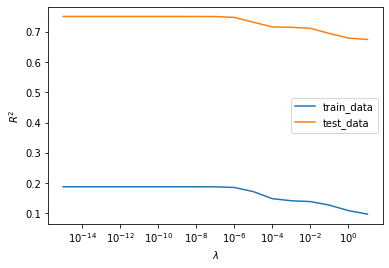

In [14]:
lam_set = [10**i for i in range(-15,2)]
lam_set.reverse()
r_result = []

for lam in lam_set:
    coeff = closed_form_2(train_data.iloc[:,1:-1], train_data.Temp, lam=lam)
    r2_test = r_square(coeff,test_data.iloc[:,1:-1],test_data.Temp)
    r2_train = r_square(coeff,train_data.iloc[:,1:-1],train_data.Temp)
    r_result.append((r2_test,r2_train))
    
temp = np.array(r_result)
plt.xscale('log')
plt.plot(lam_set,temp[:,0], label = "train_data")
plt.plot(lam_set,temp[:,1], label = "test_data")
plt.ylabel("$R^2$")
plt.xlabel("$\lambda$")
plt.legend(loc='best')

plt.show()

Then, we assume the we don't have the constant term.We should choose the  𝜆  at 1e-2, as the  𝑅2  is stable after 1e-6

Text(0, 0.5, '$R^2$')

Text(0.5, 0, '$\\lambda$')

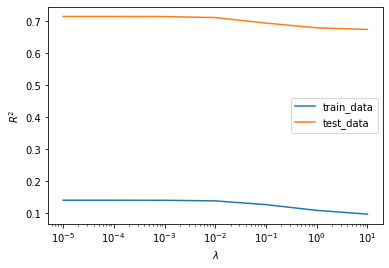

In [15]:
lam_set = [10**i for i in range(-5,2)]
lam_set.reverse()
r_result = []

for lam in lam_set:
    coeff = closed_form_2(train_data.iloc[:,1:-1], train_data.Temp, lam=lam, constant = False)
    r2_test = r_square(coeff,test_data.iloc[:,1:-1],test_data.Temp, constant = False)
    r2_train = r_square(coeff,train_data.iloc[:,1:-1],train_data.Temp, constant = False)
    r_result.append((r2_test,r2_train))
    
temp = np.array(r_result)
plt.xscale('log')
plt.plot(lam_set,temp[:,0], label = "train_data")
plt.plot(lam_set,temp[:,1], label = "test_data")
plt.ylabel("$R^2$")
plt.xlabel("$\lambda$")
plt.legend(loc='best')

plt.show()

# Problem3

### 1. From Problem 1, you can know which variables are significant, therefore you can use less variables to train model. For example, remove highly correlated and redundant features. You can propose a workflow to select feature.

1. Remove the highly correlated variable first.
2. Run regression, remove the insignificant variables step by step

In [16]:
corr = train_data.iloc[:,1:-1].corr()
corr[corr>0.9]

,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols
MEI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO2,NaN,1.00000,NaN,0.97672,NaN,NaN,NaN,NaN
CH4,NaN,NaN,1.000000,NaN,NaN,0.963616,NaN,NaN
N2O,NaN,0.97672,NaN,1.00000,NaN,NaN,NaN,NaN
CFC-11,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
CFC-12,NaN,NaN,0.963616,NaN,NaN,1.000000,NaN,NaN
TSI,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Aerosols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


As we see the CO2 highly correlated with N2O, CH4 highly correlated with CFC-12.<br>
We exam the variance of each pair variables and remove the less flactuated one.<br>
So, we need to delete CH4 and N2O.

In [17]:
train_data.iloc[:,1:].std()

MEI          0.929639
CO2         11.439691
CH4         45.669846
N2O          4.758513
CFC-11      20.987671
CFC-12      59.046642
TSI          0.401283
Aerosols     0.030014
Temp         0.181136
dtype: float64

### 2.Train a better model than the model in Problem 2.
As the explaining variables will be reduced in the feature selection part, we need to evaluate the $adj-R^2$

In [18]:
def adj_r2(coeff,x,y,constant = True):
    if constant:
        x["Constant"]=1
        
    coeff = np.matrix(coeff)
    x = np.matrix(x)
    y = y.values
    y_hat = (x@coeff.T).A1
    
    k = x.shape[1]
    n = x.shape[0]
    var1 = ((y_hat-y_hat.mean())**2).sum()
    var2 = ((y-y.mean())**2).sum()
    
    r2 = var1/var2
    r2 = 1- (1-r2)*(n-1)/(n-k-1)
    return r2


temp = train_data.iloc[:,1:-1].copy()
temp.drop(columns = ["CFC-12", "CH4", "Aerosols"], inplace = True)
coeff = closed_form_1(temp.iloc[:,1:-1], train_data.Temp)

test_temp = test_data.iloc[:,1:-1].copy()
test_temp.drop(columns = ["CFC-12", "CH4","Aerosols"], inplace = True)

print ("The adj_r2 of the new nodel is", adj_r2(coeff,temp.iloc[:,1:-1],train_data.Temp))
print ("The r2 of the test set is", r_square(coeff,test_temp.iloc[:,1:-1],test_data.Temp))


coeff = closed_form_1(train_data.iloc[:,1:-1], train_data.Temp)
print ("The adj_r2 of the origial model is", adj_r2(coeff,train_data.iloc[:,1:-1],train_data.Temp))
print ("The r2 of the test set is", r_square(coeff,test_data.iloc[:,1:-1],test_data.Temp))


The adj_r2 of the new nodel is 0.6179386094221198
The r2 of the test set is 0.03734817722359458
The adj_r2 of the origial model is 0.7427109396542091
The r2 of the test set is 0.18739109629319595


# Problem 4

**Gradient descent algorithm is an iterative process that takes us to the minimum of a function. Please write down the iterative expression for updating the solution of linear model and implement it using Python or Matlab in gradientDescent function.**
* Batch based gradient descent iterative formula is$$\beta_n = \beta_{n-1} -\frac{\alpha}{m} X'(X\beta -y)$$
The X is a batch of random choosed observation

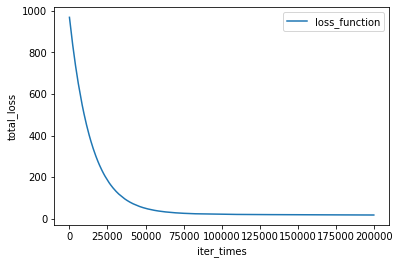

The final loss is  17.802135302289912


MEI        -0.219138
CO2        -0.098706
CH4        -0.108106
N2O         0.123284
CFC-11      0.011149
CFC-12      0.171559
TSI         0.428865
Aerosols    0.642201
Constant    0.334007
Name: correlation coefficient, dtype: float64

In [20]:
from sklearn import preprocessing

def loss(coeff,x,y):
    return (x@coeff-y).T@(x@coeff-y)

def gradientDescent(x,y,iter_max=200000, batch=100,alpha=1e-5,
                     min_gap=1e-1,constant=True):
    record = []
    if constant:
        x["Constant"]=1
    columns = x.columns
    x = np.matrix(x)
    y = np.matrix(y).T
    coeff = np.matrix(np.arange(x.shape[1])/x.shape[1]).T

    for i in range(iter_max):
        idx = np.random.choice(x.shape[0],batch)
        x_batch = x[idx,:]
        y_batch = y[idx,:]
        iteration = alpha/batch*(x_batch.T@(x_batch@coeff-y_batch))
        if np.abs(iteration.A1).all() < min_gap:
            print("iteration terminal at %s times"%i)
            break
        else:
            coeff = coeff - iteration
            record.append(loss(coeff,x,y)[0,0])
            
    plt.plot(record, label = "loss_function")
    plt.ylabel("total_loss")
    plt.xlabel("iter_times")
    plt.legend()
    plt.show()
    
    print("The final loss is ", record[-1])
    result = pd.Series(coeff.A1, index=columns, name="correlation coefficient")
    return result

min_max_scaler = preprocessing.MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(train_data.iloc[:,1:].values)
scaled_train = pd.DataFrame(scaled_train, columns = train_data.columns[1:])
result_gd = gradientDescent(scaled_train.iloc[:,:-1], scaled_train.Temp)
result_gd

#### We compare the result with the OLS analytical solution.The result of the gradient descent is better.

In [25]:
coeff_ols = closed_form_1(scaled_train.iloc[:,1:-1], scaled_train.Temp)
coeff_ols
scaled_train_x = scaled_train.iloc[:,1:-1].copy()
scaled_train_x["Constant"]=1
loss(coeff_ols,np.matrix(scaled_train_x),np.matrix(scaled_train.Temp).T)[0,0]

CO2         0.351268
CH4        -0.057338
N2O        -0.257014
CFC-11     -0.448484
CFC-12      0.700769
TSI         0.113276
Aerosols   -0.114125
Constant    0.304727
Name: correlation coefficient, dtype: float64

19.868209289567734